### IMPORTS 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

%matplotlib inline

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import io
import requests
import shutil
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding

from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

### HELPER FUNCTION

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

    # Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


### LOAD THE DATA CSV  FILE

In [3]:

path = "/Users/pavan/Desktop/ai 2nd pro"
csvfile = os.path.join(path,"CSC215_P2_Stock_Price.csv") 
df_stock = pd.read_csv(csvfile)

#print first and last 5 rows in new csv file
print(df_stock.head())
print(df_stock.tail())

print("\nNumber of columns and row currently:")
print("Data: ", df_stock.shape)


        Date      Open      High       Low     Close  Adj_Close   Volume
0  2000/3/27  3.812500  4.156250  3.812500  4.125000   4.125000  3675600
1  2000/3/28  4.125000  4.125000  4.000000  4.015625   4.015625  1077600
2  2000/3/29  4.000000  4.031250  3.953125  4.000000   4.000000   437200
3  2000/3/30  4.000000  4.000000  3.843750  3.843750   3.843750  1883600
4  2000/3/31  3.734375  3.734375  3.390625  3.390625   3.390625  7931600
          Date        Open        High         Low       Close   Adj_Close  \
4387  2017/9/1  113.790001  114.099998  112.790001  113.309998  113.309998   
4388  2017/9/5  112.519997  113.529999  111.160004  111.870003  111.870003   
4389  2017/9/6  112.029999  112.489998  110.250000  112.230003  112.230003   
4390  2017/9/7  112.459999  112.900002  112.000000  112.339996  112.339996   
4391  2017/9/8  112.300003  114.790001  112.010002  113.190002  113.190002   

       Volume  
4387   950000  
4388  1805200  
4389  2136700  
4390  1251600  
4391  1611700

#### Drop missing values and columns 

In [4]:
# Storing in a different dataframe before dropping the columns
df_newstock= df_stock

# Drop rows if there are any missing values
df_newstock.isnull().all(axis=1)
df_newstock = df_newstock.dropna()

# Dropping the columns Date and Adj_Close as mentioned
df_newstock=df_newstock.drop(['Date', 'Adj_Close'], axis=1)

#print first 5 rows in new csv file
print(df_newstock.head())

#data about count of NaN in each column
print(df_newstock.isnull().sum())

print("\nNumber of col/row currently:")
print("Data: ", df_newstock.shape)

       Open      High       Low     Close   Volume
0  3.812500  4.156250  3.812500  4.125000  3675600
1  4.125000  4.125000  4.000000  4.015625  1077600
2  4.000000  4.031250  3.953125  4.000000   437200
3  4.000000  4.000000  3.843750  3.843750  1883600
4  3.734375  3.734375  3.390625  3.390625  7931600
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Number of col/row currently:
Data:  (4392, 5)


In [5]:
# creating a copy of the column, Close
df_newstock['y'] = df_newstock['Close']
#print first 5 rows in new csv file
print(df_newstock.head())

print("\nNumber of col/row currently:")
print("Data: ", df_newstock.shape)

       Open      High       Low     Close   Volume         y
0  3.812500  4.156250  3.812500  4.125000  3675600  4.125000
1  4.125000  4.125000  4.000000  4.015625  1077600  4.015625
2  4.000000  4.031250  3.953125  4.000000   437200  4.000000
3  4.000000  4.000000  3.843750  3.843750  1883600  3.843750
4  3.734375  3.734375  3.390625  3.390625  7931600  3.390625

Number of col/row currently:
Data:  (4392, 6)


### NORMALIZE NUMERICAL FEATURES

In [6]:
#Normalizing except  last column y
for column in df_newstock.columns:
  if  column != 'y':
    encode_numeric_zscore(df_newstock, column)

#print first  5 rows in new csv file to check for normalizing
print(df_newstock.head())

       Open      High       Low     Close    Volume         y
0 -0.894209 -0.885022 -0.892306 -0.884364  1.104812  4.125000
1 -0.883762 -0.886056 -0.885975 -0.888021 -0.497301  4.015625
2 -0.887941 -0.889159 -0.887558 -0.888543 -0.892217  4.000000
3 -0.887941 -0.890194 -0.891251 -0.893768 -0.000263  3.843750
4 -0.896820 -0.898986 -0.906551 -0.908920  3.729366  3.390625


In [7]:
# Set all column other than y as input or 'x'
x = df_newstock.iloc[:,df_newstock.columns != 'y']
x = np.array(x, dtype=np.float32)

# Set the y column as output or 'y'
y = np.array(df_newstock['y'].values, dtype=np.float32)
print(x.shape)
print(y.shape)

(4392, 5)
(4392,)


In [8]:
import numpy as np

def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [9]:
SEQUENCE_SIZE = 7
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)
x_lstseq, y_lstseq = to_sequences(SEQUENCE_SIZE, x, y)

#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of x_lstseq: {}".format(x_lstseq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))
print("Shape of y_lstseq: {}".format(y_lstseq.shape))


Shape of x_lstseq: (4385, 7, 1, 5)
Shape of y_lstseq: (4385,)


In [10]:
x_newseq=x_lstseq.reshape(4385,1,7,5)
print("Shape of x_newseq: {}".format(x_newseq.shape))


Shape of x_newseq: (4385, 1, 7, 5)


### Split train and test date 70/30

In [11]:
##Split train and test date 70/30
x_train, x_test, y_train, y_test = train_test_split(x_newseq, y_lstseq, test_size=0.3, random_state=0)

print("Shape of x_train :{}".format(x_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))

print("Shape of y_train :{}".format(y_train.shape))
print("Shape of y_test  :{}".format(y_test.shape))

type(x_test),type(y_test),type(x_train),type(y_train)


Shape of x_train :(3069, 1, 7, 5)
Shape of x_test  :(1316, 1, 7, 5)
Shape of y_train :(3069,)
Shape of y_test  :(1316,)


(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [12]:
x_train[:1]

array([[[[-0.734505  , -0.732966  , -0.7310747 , -0.7309651 ,
          -0.06735727],
         [-0.73041004, -0.73056626, -0.727276  , -0.729544  ,
          -0.49532732],
         [-0.72932357, -0.7331315 , -0.7288799 , -0.7310487 ,
           0.19953819],
         [-0.73041004, -0.73362803, -0.72980845, -0.7323026 ,
          -0.29873243],
         [-0.73041004, -0.729656  , -0.72702277, -0.7270361 ,
          -0.1386445 ],
         [-0.7264822 , -0.7265114 , -0.7235618 , -0.7266181 ,
           0.722969  ],
         [-0.7260643 , -0.72808367, -0.7238995 , -0.72536415,
           0.03180351]]]], dtype=float32)

###  CNN

Optimizer  used:  adam  Activation Function used :  relu
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 6, 64)          704       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               38500     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dens

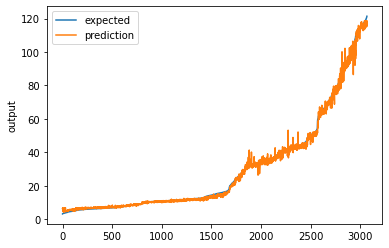

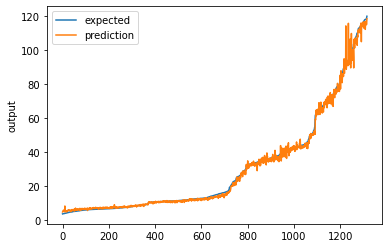

Optimizer  used:  adam  Activation Function used :  sigmoid
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 6, 64)          704       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               38500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 39,305
Trainable params: 39,305
Non-trainable 

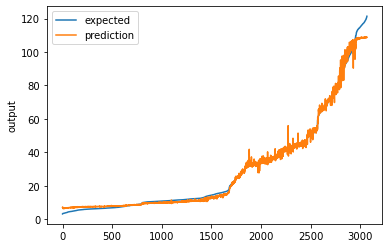

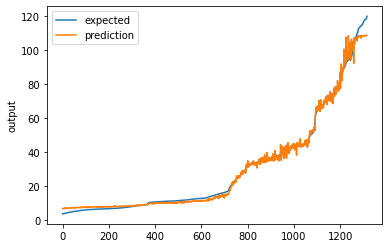

Optimizer  used:  adam  Activation Function used :  tanh
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 6, 64)          704       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               38500     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 39,305
Trainable params: 39,305
Non-trainable par

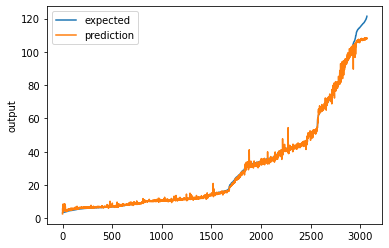

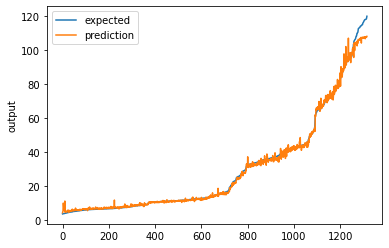

Optimizer  used:  sgd  Activation Function used :  relu
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1, 6, 64)          704       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 6, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               38500     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 39,305
Trainable params: 39,305
Non-trainable para

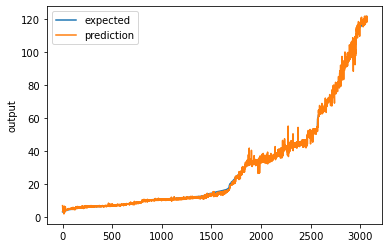

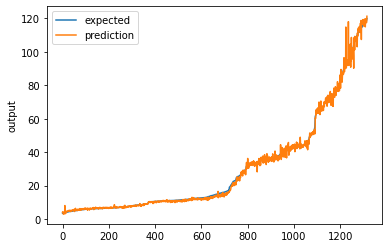

Optimizer  used:  sgd  Activation Function used :  sigmoid
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 1, 6, 64)          704       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 6, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               38500     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 39,305
Trainable params: 39,305
Non-trainable p

Epoch 67/1000
3069/3069 - 0s - loss: 38.9875 - acc: 0.0000e+00 - val_loss: 4.4911 - val_acc: 0.0000e+00
Epoch 68/1000
3069/3069 - 0s - loss: 36.8207 - acc: 0.0000e+00 - val_loss: 4.3272 - val_acc: 0.0000e+00
Epoch 00068: early stopping
Score_train (RMSE): 2.043684482574463
Score_test (RMSE): 2.0720012187957764


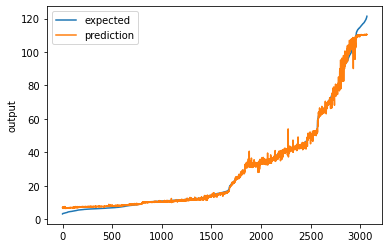

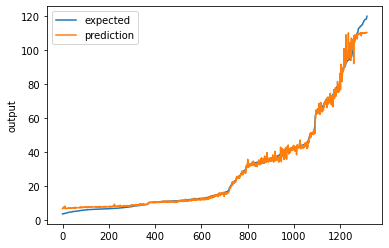

Optimizer  used:  sgd  Activation Function used :  tanh
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1, 6, 64)          704       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               38500     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 39,305
Trainable params: 39,305
Non-trainable para

3069/3069 - 0s - loss: 22.3638 - acc: 0.0000e+00 - val_loss: 4.8845 - val_acc: 0.0000e+00
Epoch 68/1000
3069/3069 - 0s - loss: 23.8523 - acc: 0.0000e+00 - val_loss: 4.5080 - val_acc: 0.0000e+00
Epoch 69/1000
3069/3069 - 0s - loss: 24.6922 - acc: 0.0000e+00 - val_loss: 3.5952 - val_acc: 0.0000e+00
Epoch 70/1000
3069/3069 - 0s - loss: 25.2419 - acc: 0.0000e+00 - val_loss: 6.1085 - val_acc: 0.0000e+00
Epoch 71/1000
3069/3069 - 0s - loss: 23.4171 - acc: 0.0000e+00 - val_loss: 3.5515 - val_acc: 0.0000e+00
Epoch 72/1000
3069/3069 - 0s - loss: 22.2766 - acc: 0.0000e+00 - val_loss: 3.3110 - val_acc: 0.0000e+00
Epoch 73/1000
3069/3069 - 0s - loss: 23.9673 - acc: 0.0000e+00 - val_loss: 2.9814 - val_acc: 0.0000e+00
Epoch 74/1000
3069/3069 - 0s - loss: 23.7107 - acc: 0.0000e+00 - val_loss: 3.2594 - val_acc: 0.0000e+00
Epoch 75/1000
3069/3069 - 0s - loss: 23.5852 - acc: 0.0000e+00 - val_loss: 3.4956 - val_acc: 0.0000e+00
Epoch 76/1000
3069/3069 - 0s - loss: 24.2719 - acc: 0.0000e+00 - val_loss: 4.3

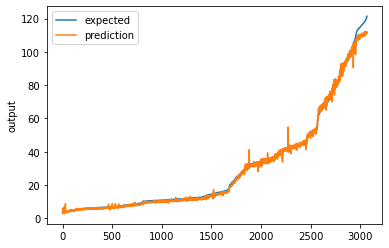

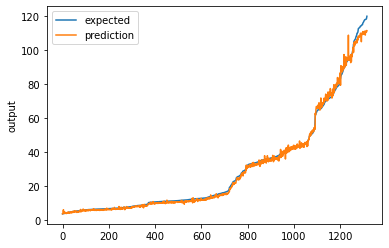

In [13]:
# List of  Activation functions
activation_functions = ['relu','sigmoid','tanh']
# List of posible optimizers
optimizers = ['adam','sgd']

# Loop through all combination of optimizers and activation functions
for optimizer in optimizers:
  for activ_function in activation_functions:
    print("Optimizer  used: ", optimizer, " Activation Function used : ", activ_function)
    model_cnn = Sequential()
    model_cnn.add(Conv2D(64, kernel_size=(1,2), strides=(1, 1), padding='valid',input_shape=(1,7,5), activation =activ_function))
    model_cnn.add(MaxPooling2D(pool_size=(1,1)))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(100, activation =activ_function))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy'])
    model_cnn.summary()
    
    monitor= EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="best_weights_cnn_relu.hdf5", verbose=0, save_best_only=True) 
    # save best model
    history = model_cnn.fit(x_train, y_train, validation_data= (x_test, y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
    model_cnn.load_weights('best_weights_cnn_relu.hdf5')
    # load weights from best model
    pred_train = model_cnn.predict(x_train)
    pred_test = model_cnn.predict(x_test)

    rmse = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    print("Score_train (RMSE): {}".format(rmse))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, pred_test))
    print("Score_test (RMSE): {}".format(rmse))

    #regression lift Chart
    chart_regression(pred_train.flatten(),y_train, sort=True)
    chart_regression(pred_test.flatten(),y_test, sort=True)

Optimizer  used:  adam  Activation Function used :  relu
Model: "sequential_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_109 (Flatten)        (None, 448)               0         
_________________________________________________________________
dense_218 (Dense)            (None, 64)                28736     
_________________________________________________________________
dropout_109 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_219 (Dense)            (None, 1)                 65        
Total params: 31,745
Trainable params: 31,745
Non-trainable p

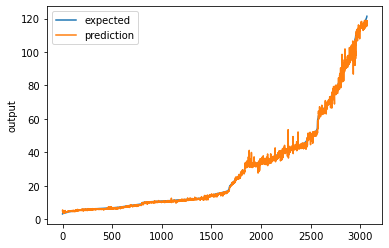

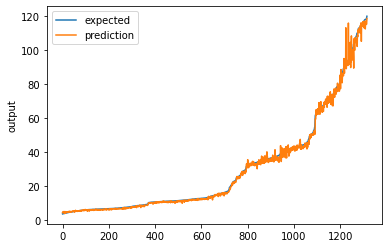

Optimizer  used:  adam  Activation Function used :  sigmoid
Model: "sequential_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_110 (Flatten)        (None, 448)               0         
_________________________________________________________________
dense_220 (Dense)            (None, 64)                28736     
_________________________________________________________________
dropout_110 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_221 (Dense)            (None, 1)                 65        
Total params: 31,745
Trainable params: 31,745
Non-trainabl

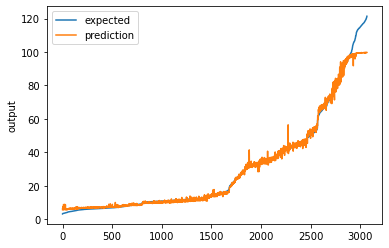

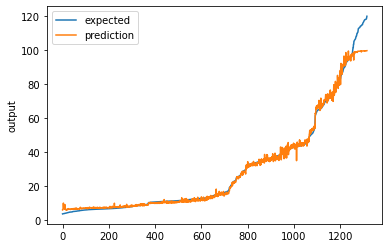

Optimizer  used:  adam  Activation Function used :  tanh
Model: "sequential_130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_127 (Conv2D)          (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_111 (Flatten)        (None, 448)               0         
_________________________________________________________________
dense_222 (Dense)            (None, 64)                28736     
_________________________________________________________________
dropout_111 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_223 (Dense)            (None, 1)                 65        
Total params: 31,745
Trainable params: 31,745
Non-trainable p

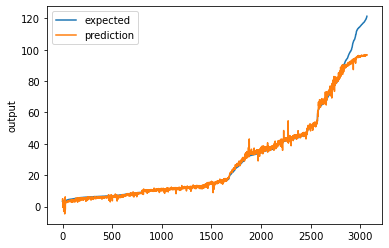

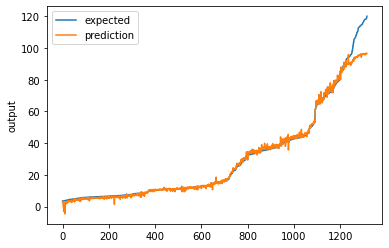

Optimizer  used:  sgd  Activation Function used :  relu
Model: "sequential_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_128 (Conv2D)          (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_112 (Flatten)        (None, 448)               0         
_________________________________________________________________
dense_224 (Dense)            (None, 64)                28736     
_________________________________________________________________
dropout_112 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_225 (Dense)            (None, 1)                 65        
Total params: 31,745
Trainable params: 31,745
Non-trainable pa

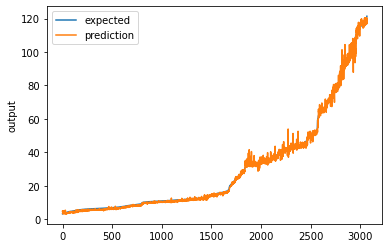

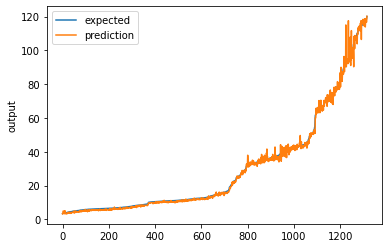

Optimizer  used:  sgd  Activation Function used :  sigmoid
Model: "sequential_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_113 (Flatten)        (None, 448)               0         
_________________________________________________________________
dense_226 (Dense)            (None, 64)                28736     
_________________________________________________________________
dropout_113 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_227 (Dense)            (None, 1)                 65        
Total params: 31,745
Trainable params: 31,745
Non-trainable

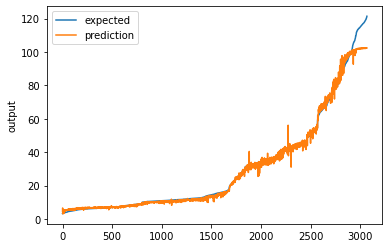

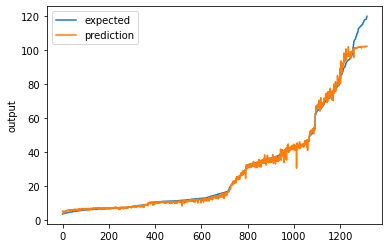

Optimizer  used:  sgd  Activation Function used :  tanh
Model: "sequential_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_130 (Conv2D)          (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_114 (Flatten)        (None, 448)               0         
_________________________________________________________________
dense_228 (Dense)            (None, 64)                28736     
_________________________________________________________________
dropout_114 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_229 (Dense)            (None, 1)                 65        
Total params: 31,745
Trainable params: 31,745
Non-trainable pa

Epoch 67/1000
3069/3069 - 0s - loss: 43.3964 - acc: 0.0000e+00 - val_loss: 11.4599 - val_acc: 0.0000e+00
Epoch 00067: early stopping
Score_train (RMSE): 3.5321757793426514
Score_test (RMSE): 3.3849523067474365


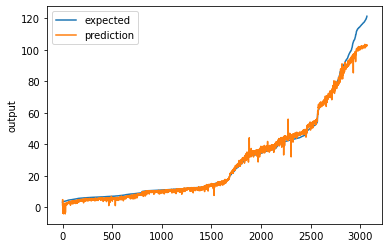

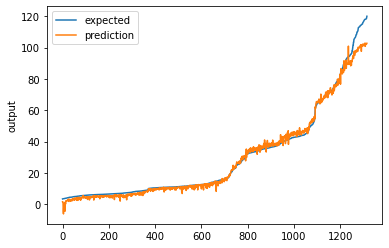

In [179]:
# List of  Activation functions
activation_functions = ['relu','sigmoid','tanh']
# List of posible optimizers
optimizers = ['adam','sgd']

# Loop through all combination of optimizers and activation functions
for optimizer in optimizers:
  for activ_function in activation_functions:
    print("Optimizer  used: ", optimizer, " Activation Function used : ", activ_function)
    model_cnn = Sequential()
    model_cnn.add(Conv2D(64, kernel_size=(3,3), strides=(1, 1), padding='same',input_shape=(1,7,5)))
    model_cnn.add(MaxPooling2D(pool_size=(1,1), strides=None))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(64, activation =activ_function))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy'])
    model_cnn.summary()
    
    monitor= EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="best_weights_cnn_relu.hdf5", verbose=0, save_best_only=True) 
    # save best model
    history = model_cnn.fit(x_train, y_train, validation_data= (x_test, y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
    model_cnn.load_weights('best_weights_cnn_relu.hdf5')
    # load weights from best model
    pred_train = model_cnn.predict(x_train)
    pred_test = model_cnn.predict(x_test)

    rmse = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    print("Score_train (RMSE): {}".format(rmse))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, pred_test))
    print("Score_test (RMSE): {}".format(rmse))

    #regression lift Chart
    chart_regression(pred_train.flatten(),y_train, sort=True)
    chart_regression(pred_test.flatten(),y_test, sort=True)